# Preprocess read count

This is only for our data. For other datasets see ```A01_get_scrnaseq_tpm.ipynb```

In [1]:
import os, pickle, re, glob, time
import pandas as pd
import numpy as np
np.set_printoptions(precision=2)

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
from scipy import stats
from collections import Counter

sns.set_style('ticks')
pd.set_option('precision', 2)

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

### Cell line info

In [2]:
cell_info_df = pd.read_csv('../data/HN_patient_specific/cellInfo.csv', index_col=0)
cell_info_df.loc[:, 'batch'] = [c[0:3] for c in cell_info_df.index]

cell_list = sorted(cell_info_df.index)
print (len(cell_list))

1247


In [3]:
# old files [TO BE REMOVED]
cell_info_df2 = pd.read_csv('../data/HN_patient_specific/old_norm_cluster_results/cellInfo2.csv', index_col=0)
old_sel_cell_list = cell_info_df2.index

old_removed_cell_list = [c for c in cell_list if c not in old_sel_cell_list]
old_removed_cell_list

['RHO341', 'RHO349', 'RHO533', 'RHO566', 'RHO606', 'RHO614']

### Count

Only RHO* we have everything. For previous batches, we only have count, tpm, fpkm.

In [4]:
count_df = pd.read_csv('../data/HN_patient_specific/star_rsem_output/HN120-182/countdata.csv', index_col=0)
count_df = count_df.set_index('mat57[, 1]')
count_df.index.name = ''

In [5]:
print (count_df.shape)
count_df.head()

(54999, 1247)


,RHH2176,RHH2177,RHH2178,RHH2179,RHH2180,RHH2181,RHH2182,RHH2183,RHH2184,RHH2185,...,RHO708,RHO709,RHO710,RHO711,RHO712,RHO713,RHO714,RHO715,RHO716,RHO717
,,,,,,,,,,,,,,,,,,,,,
TSPAN6,2.0,7.0,132.0,58.0,11.0,115.0,2.0,13.0,27.0,1.0,...,295.0,116.0,0.0,121.0,38.0,116.0,234.0,227.0,17.0,71.0
TNMD,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
DPM1,0.0,1.0,50.0,24.0,24.0,40.0,3.0,3.0,4.0,1.0,...,341.0,11.0,0.0,23.0,16.0,189.0,291.0,121.0,20.0,26.0
SCYL3,0.0,0.0,36.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,...,25.0,4.0,0.0,20.0,0.0,0.0,0.0,2.0,0.0,6.0
C1orf112,0.0,0.0,0.0,4.0,2.0,0.0,9.0,0.0,0.0,0.0,...,10.0,0.0,0.0,1.0,0.0,3.0,1.0,38.0,5.0,0.0


##### There are many unmapped reads in few samples

In [6]:
sample_output_df1 = pd.read_csv('../data/HN_patient_specific/star_rsem_output/RHO238/star/RHO238_hg19_ReadsPerGene.out.tab.desc', sep='\t', index_col=0)

sample_output_df2 = pd.read_csv('../data/HN_patient_specific/star_rsem_output/RHO238/rsem/RHO238_hg19_RSEM.genes.results', sep='\t', index_col=0)

In [7]:
# sample_output_df1.loc[sample_output_df1.index.str.contains('ENSG')].sum()

In [8]:
# sample_output_df1.tail()

### TPM

In [9]:
tpm_df = pd.read_csv('../data/HN_patient_specific/star_rsem_output/HN120-182/tpm.csv', index_col=0)

In [10]:
print (tpm_df.shape)
tpm_df.head()

(57268, 768)


,RHH2176,RHH2177,RHH2178,RHH2179,RHH2180,RHH2181,RHH2182,RHH2183,RHH2184,RHH2185,...,RHC6644,RHC6645,RHC6646,RHC6647,RHC6648,RHC6649,RHC6650,RHC6651,RHC6652,RHC6653
1,49.14,48.85,131.23,178.24,23.44,153.69,9.38,96.24,81.05,10.09,...,0.99,76.64,22.62,67.69,28.06,137.69,42.52,41.95,108.81,265.52
2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,0.00,25.66,123.04,159.22,110.39,115.40,51.75,47.94,25.92,12.69,...,0.73,76.17,83.42,90.52,164.33,13.15,138.98,24.68,117.45,0.00
4,0.00,0.00,26.77,4.13,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,4.57,0.67,0.32,1.27,4.79,0.00
5,0.00,0.00,0.00,29.61,2.47,0.00,24.26,0.00,0.00,0.00,...,0.00,2.41,13.14,29.39,47.68,0.00,61.45,3.65,10.68,0.00


In [11]:
tpm_df.sum().head()

RHH2176    1.00e+06
RHH2177    1.00e+06
RHH2178    1.00e+06
RHH2179    1.00e+06
RHH2180    1.00e+06
dtype: float64

In [12]:
gene_df = pd.merge(sample_output_df1[['gene_type', 'gene_name']], sample_output_df2[['transcript_id(s)', 'length', 'effective_length']], left_index=True, right_index=True, how='right')

gene_id_name_dict = dict(zip(gene_df.index, gene_df['gene_name']))
gene_df.to_csv('../data/HN_patient_specific/gene.csv')

tpm_gene_list = gene_df.index
tpm_df.index = tpm_gene_list
tpm_df.head()

,RHH2176,RHH2177,RHH2178,RHH2179,RHH2180,RHH2181,RHH2182,RHH2183,RHH2184,RHH2185,...,RHC6644,RHC6645,RHC6646,RHC6647,RHC6648,RHC6649,RHC6650,RHC6651,RHC6652,RHC6653
gene_id,,,,,,,,,,,,,,,,,,,,,
ENSG00000000003.10,49.14,48.85,131.23,178.24,23.44,153.69,9.38,96.24,81.05,10.09,...,0.99,76.64,22.62,67.69,28.06,137.69,42.52,41.95,108.81,265.52
ENSG00000000005.5,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
ENSG00000000419.8,0.00,25.66,123.04,159.22,110.39,115.40,51.75,47.94,25.92,12.69,...,0.73,76.17,83.42,90.52,164.33,13.15,138.98,24.68,117.45,0.00
ENSG00000000457.9,0.00,0.00,26.77,4.13,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,4.57,0.67,0.32,1.27,4.79,0.00
ENSG00000000460.12,0.00,0.00,0.00,29.61,2.47,0.00,24.26,0.00,0.00,0.00,...,0.00,2.41,13.14,29.39,47.68,0.00,61.45,3.65,10.68,0.00


##### additional tpm files

In [13]:
missing_tmp_cell_list = [c for c in cell_list if c not in tpm_df.columns]
len(missing_tmp_cell_list) # all are RHO

479

Converting FPKM to TPM for MUX5757files

In [14]:
##### Check for converting FPKM to TPM

# temp_tpm_df = pd.read_csv('../data/HN_patient_specific/star_rsem_output/MUX5761files/MUX5761-TPMmatrix.tsv', index_col=0, sep='\t')
# temp_fpkm_df = pd.read_csv('../data/HN_patient_specific/star_rsem_output/MUX5761files/MUX5761-FPKMmatrix.tsv', index_col=0, sep='\t')

# x = temp_tpm_df.values.flatten()
# y = ((temp_fpkm_df / temp_fpkm_df.sum()) * 1000000).values.flatten()
# plt.scatter(x, y)

In [15]:
temp_fpkm_df = pd.read_csv('../data/HN_patient_specific/star_rsem_output/MUX5757files/MUX5757-FPKMmatrix.tsv', index_col=0, sep='\t')
temp_tpm_df = (temp_fpkm_df / temp_fpkm_df.sum()) * 1000000
temp_tpm_df.to_csv('../data/HN_patient_specific/star_rsem_output/MUX5757files/MUX5757-TPMmatrix.tsv', sep='\t')

Read additional files

In [16]:
mux_list = ['MUX5757', 'MUX5758', 'MUX5759', 'MUX5760', 'MUX5761']

tpm_df_list = []
for mux in mux_list:
    df = pd.read_csv('../data/HN_patient_specific/star_rsem_output/{}files/{}-TPMmatrix.tsv'.format(mux, mux), index_col=0, sep='\t')
    tpm_df_list += [df]

In [17]:
temp_df2 = pd.concat(tpm_df_list, axis=1)
temp_df2.index = tpm_gene_list

temp_df2.shape

(57268, 479)

In [18]:
tpm_df = pd.concat([tpm_df, temp_df2], axis=1)
tpm_df.head()

,RHH2176,RHH2177,RHH2178,RHH2179,RHH2180,RHH2181,RHH2182,RHH2183,RHH2184,RHH2185,...,RHO708,RHO709,RHO710,RHO711,RHO712,RHO713,RHO714,RHO715,RHO716,RHO717
gene_id,,,,,,,,,,,,,,,,,,,,,
ENSG00000000003.10,49.14,48.85,131.23,178.24,23.44,153.69,9.38,96.24,81.05,10.09,...,127.02,121.74,0.0,101.40,27.24,72.80,121.54,131.68,18.73,45.72
ENSG00000000005.5,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00
ENSG00000000419.8,0.00,25.66,123.04,159.22,110.39,115.40,51.75,47.94,25.92,12.69,...,316.68,24.94,0.0,41.63,28.49,247.13,326.69,151.61,27.20,36.17
ENSG00000000457.9,0.00,0.00,26.77,4.13,0.00,0.00,0.00,0.00,0.00,0.00,...,3.62,1.41,0.0,5.64,0.00,0.00,0.00,0.39,0.00,5.66
ENSG00000000460.12,0.00,0.00,0.00,29.61,2.47,0.00,24.26,0.00,0.00,0.00,...,2.50,0.00,0.0,0.49,0.00,0.90,1.67,55.43,7.31,0.00


No duplicates gene

In [19]:
tpm_df.index.shape, len(set(tpm_df.index))

((57268,), 57268)

Drop genes with zero count

In [20]:
non_zero_gene_list = tpm_df.index[tpm_df.sum(axis=1) > 0]
tpm_df = tpm_df.loc[non_zero_gene_list]

tpm_df.shape, [c for c in cell_list if c not in tpm_df.columns]

((34923, 1247), [])

##### Plot number of genes per cells

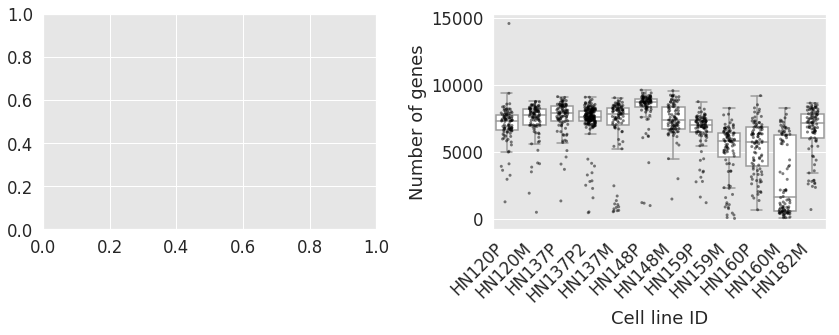

In [21]:
# count number of expressed genes
temp_df = pd.DataFrame((tpm_df > 0).sum(), columns=['count'])
temp_df = pd.merge(temp_df, cell_info_df[['cell_line_id', 'batch']], left_index=True, right_index=True)
temp_df

sns.set(font_scale=1.5)
sns.set_style("darkgrid", {"axes.facecolor": ".9"})
fig, axes = plt.subplots(ncols=2, figsize=(12, 5))

# sns.stripplot(data=temp_df, x='batch', y='count', jitter=0.2, alpha=0.7, ax=axes[0])
# sns.boxplot(data=temp_df, x='batch', y='count', fliersize=0, color='white', ax=axes[0])
# axes[0].axhline(y=5000, color='grey')
# # axes[0].set(yscale="log")

sns.stripplot(data=temp_df, x='cell_line_id', y='count', jitter=0.2, alpha=0.5, ax=axes[1], size=3, color='black')
sns.boxplot(data=temp_df, x='cell_line_id', y='count', fliersize=0, color='white', ax=axes[1])
# axes[1].set(yscale="log")
# axes[1].axhline(y=5000, color='grey')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right')
axes[1].set_ylabel('Number of genes')
axes[1].set_xlabel('Cell line ID')

plt.tight_layout()
plt.savefig('../figure/supplementary_number_genes_per_cell.svg')

In [22]:
temp_df.sort_values('count').tail()

,count,cell_line_id,batch
RHH2555,9377,HN148P,RHH
RHH2484,9386,HN148P,RHH
RHC6602,9561,HN148M,RHC
RHH2539,9600,HN148P,RHH
RHH2226,14558,HN120P,RHH


In [23]:
temp_df.describe()

,count
count,1247.00
mean,6626.96
std,2173.22
min,38.00
25%,6218.50
50%,7297.00
75%,8043.00
max,14558.00


##### Plot library size per cells

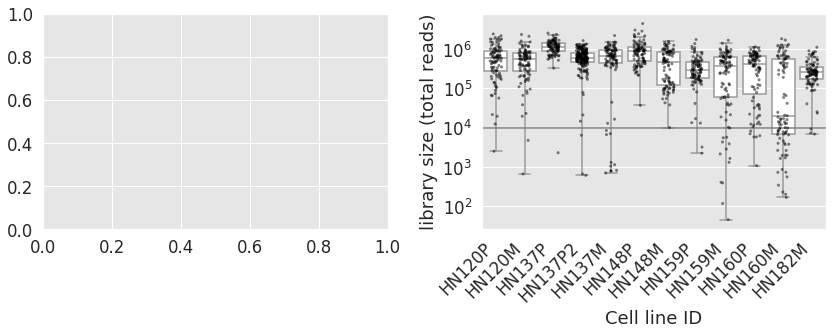

In [24]:
# calculate library size per cell
temp_df = pd.DataFrame(count_df.sum(), columns=['lib_size'])
temp_df = pd.merge(temp_df, cell_info_df[['cell_line_id', 'batch']], left_index=True, right_index=True)
temp_df

sns.set(font_scale=1.5)
sns.set_style("darkgrid", {"axes.facecolor": ".9"})
fig, axes = plt.subplots(ncols=2, figsize=(12, 5))

# sns.stripplot(data=temp_df, x='batch', y='lib_size', jitter=0.2, alpha=0.7, ax=axes[0])
# sns.boxplot(data=temp_df, x='batch', y='lib_size', fliersize=0, color='white', ax=axes[0])
# axes[0].axhline(y=10000, color='grey')
# axes[0].set(yscale="log")

sns.stripplot(data=temp_df, x='cell_line_id', y='lib_size', jitter=0.2, alpha=0.5, ax=axes[1], size=3, color='black')
sns.boxplot(data=temp_df, x='cell_line_id', y='lib_size', fliersize=0, color='white', ax=axes[1])
axes[1].set(yscale="log")
axes[1].axhline(y=10000, color='grey')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right')
axes[1].set_ylabel('library size (total reads)')
axes[1].set_xlabel('Cell line ID')

plt.tight_layout()
plt.savefig('../figure/supplementary_number_reads_per_cell.svg')

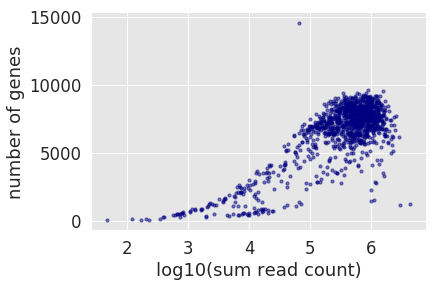

In [25]:
x = count_df.sum().values
y = (tpm_df > 0).sum().values
plt.scatter(np.log10(x), y, s=10, alpha=0.5, color='navy')

plt.xlabel('log10(sum read count)')
plt.ylabel('number of genes')

sns.despine()

##### Filter cells

- Remove the one with > 10000 genes (possible duplet)
- Library size >= 10000

In [26]:
selected_cell_list = tpm_df.columns[((tpm_df > 0).sum() < 10000) & (count_df.sum() >= 10000)]
len(selected_cell_list)

1171

In [27]:
tpm_df = tpm_df[selected_cell_list]

In [28]:
cell_info_df.loc[selected_cell_list].groupby('cell_line_id').count()

,patient_id,origin,batch
cell_line_id,,,
HN120M,94,94,94
HN120P,94,94,94
HN137M,86,86,86
HN137P,95,95,95
HN137P2,189,189,189
HN148M,96,96,96
HN148P,96,96,96
HN159M,83,83,83
HN159P,94,94,94


In [30]:
cell_info_df.to_csv('../preprocessed_data/HN_patient_specific/cell_info.csv')

##### Filter genes

In [33]:
min_n_cells = int(0.05 * tpm_df.shape[1])
min_n_cells

58

In [34]:
tpm_df.shape

(34923, 1171)

In [35]:
selected_gene_list = tpm_df.index[((tpm_df > 0).T.sum() >= min_n_cells)]
len(selected_gene_list)

15185

In [36]:
tpm_df = tpm_df.loc[selected_gene_list]
print (tpm_df.shape)

(15185, 1171)


In [37]:
tpm_df.head()

,RHH2176,RHH2177,RHH2178,RHH2179,RHH2180,RHH2181,RHH2182,RHH2183,RHH2184,RHH2185,...,RHO707,RHO708,RHO709,RHO711,RHO712,RHO713,RHO714,RHO715,RHO716,RHO717
gene_id,,,,,,,,,,,,,,,,,,,,,
ENSG00000000003.10,49.14,48.85,131.23,178.24,23.44,153.69,9.38,96.24,81.05,10.09,...,46.83,127.02,121.74,101.40,27.24,72.80,121.54,131.68,18.73,45.72
ENSG00000000419.8,0.00,25.66,123.04,159.22,110.39,115.40,51.75,47.94,25.92,12.69,...,95.78,316.68,24.94,41.63,28.49,247.13,326.69,151.61,27.20,36.17
ENSG00000000457.9,0.00,0.00,26.77,4.13,0.00,0.00,0.00,0.00,0.00,0.00,...,2.41,3.62,1.41,5.64,0.00,0.00,0.00,0.39,0.00,5.66
ENSG00000000460.12,0.00,0.00,0.00,29.61,2.47,0.00,24.26,0.00,0.00,0.00,...,6.01,2.50,0.00,0.49,0.00,0.90,1.67,55.43,7.31,0.00
ENSG00000000971.11,0.00,7.30,75.75,0.00,32.28,0.00,4.91,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.32,1.62,0.00,0.00,7.88


In [50]:
tpm_df.to_csv('../data/HN_patient_specific/hn_sc_tpm.csv')

# Regenerate the mat_norm

In [74]:
count_df = pd.read_csv('../data/HN_patient_specific/star_rsem_output/HN120-182/countdata.csv', index_col=0)
count_df = count_df.set_index('mat57[, 1]')
count_df.index.name = ''
print (count_df.shape)
count_df.head()

(54999, 1247)


,RHH2176,RHH2177,RHH2178,RHH2179,RHH2180,RHH2181,RHH2182,RHH2183,RHH2184,RHH2185,...,RHO708,RHO709,RHO710,RHO711,RHO712,RHO713,RHO714,RHO715,RHO716,RHO717
,,,,,,,,,,,,,,,,,,,,,
TSPAN6,2.0,7.0,132.0,58.0,11.0,115.0,2.0,13.0,27.0,1.0,...,295.0,116.0,0.0,121.0,38.0,116.0,234.0,227.0,17.0,71.0
TNMD,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
DPM1,0.0,1.0,50.0,24.0,24.0,40.0,3.0,3.0,4.0,1.0,...,341.0,11.0,0.0,23.0,16.0,189.0,291.0,121.0,20.0,26.0
SCYL3,0.0,0.0,36.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,...,25.0,4.0,0.0,20.0,0.0,0.0,0.0,2.0,0.0,6.0
C1orf112,0.0,0.0,0.0,4.0,2.0,0.0,9.0,0.0,0.0,0.0,...,10.0,0.0,0.0,1.0,0.0,3.0,1.0,38.0,5.0,0.0


In [57]:
old_mat_norm_df = pd.read_csv('../data/HN_patient_specific/old_norm_cluster_results/mat_norm.csv', index_col=0)
print (old_mat_norm_df.shape)
old_mat_norm_df.head()

(26968, 1241)


,RHH2176,RHH2177,RHH2178,RHH2179,RHH2180,RHH2181,RHH2182,RHH2183,RHH2184,RHH2185,...,RHO708,RHO709,RHO710,RHO711,RHO712,RHO713,RHO714,RHO715,RHO716,RHO717
TSPAN6,0.71,0.67,1.18,1.38,0.33,1.28,0.17,1.10,0.91,0.06,...,1.45,1.34,0.0,1.26,0.52,1.00,1.38,1.41,0.21,0.76
DPM1,0.00,0.13,0.62,0.80,0.62,0.64,0.24,0.38,0.20,0.06,...,1.56,0.24,0.0,0.39,0.25,1.33,1.54,0.97,0.25,0.35
SCYL3,0.00,0.00,0.48,0.19,0.00,0.00,0.00,0.00,0.00,0.00,...,0.24,0.09,0.0,0.35,0.00,0.00,0.00,0.03,0.00,0.09
C1orf112,0.00,0.00,0.00,0.19,0.07,0.00,0.59,0.00,0.00,0.00,...,0.10,0.00,0.0,0.02,0.00,0.04,0.01,0.42,0.07,0.00
FGR,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [62]:
factor_df = pd.DataFrame(count_df.sum() / 10000, columns=['factor'])
factor_df.head()

,factor
RHH2176,1.95
RHH2177,7.38
RHH2178,58.35
RHH2179,19.53
RHH2180,27.75


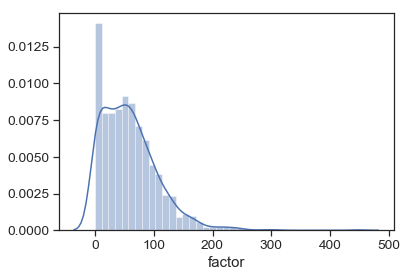

In [100]:
sns.distplot(factor_df['factor'])

In [71]:
new_mat_norm_df = np.log((count_df / factor_df['factor']) + 1)
new_mat_norm_df.head()

,RHH2176,RHH2177,RHH2178,RHH2179,RHH2180,RHH2181,RHH2182,RHH2183,RHH2184,RHH2185,...,RHO708,RHO709,RHO710,RHO711,RHO712,RHO713,RHO714,RHO715,RHO716,RHO717
,,,,,,,,,,,,,,,,,,,,,
TSPAN6,0.71,0.67,1.18,1.38,0.33,1.28,0.17,1.10,0.91,0.06,...,1.45,1.34,0.0,1.26,0.52,1.00,1.38,1.41,0.21,0.76
TNMD,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00
DPM1,0.00,0.13,0.62,0.80,0.62,0.64,0.24,0.38,0.20,0.06,...,1.56,0.24,0.0,0.39,0.25,1.33,1.55,0.97,0.25,0.35
SCYL3,0.00,0.00,0.48,0.19,0.00,0.00,0.00,0.00,0.00,0.00,...,0.24,0.09,0.0,0.35,0.00,0.00,0.00,0.03,0.00,0.09
C1orf112,0.00,0.00,0.00,0.19,0.07,0.00,0.60,0.00,0.00,0.00,...,0.10,0.00,0.0,0.02,0.00,0.04,0.01,0.42,0.07,0.00


In [96]:
new_mat_norm_sum_df = new_mat_norm_df.reset_index().groupby('').sum()

In [97]:
selected_gene_name_list = new_mat_norm_sum_df.index[((new_mat_norm_sum_df > 0).T.sum() >= min_n_cells)]
len(selected_gene_name_list)

14882

In [98]:
new_mat_norm_sum_df = new_mat_norm_sum_df.loc[selected_gene_name_list, selected_cell_list]
new_mat_norm_sum_df.shape

(14882, 1171)

In [99]:
new_mat_norm_sum_df.to_csv('../data/HN_patient_specific/hn_mat_norm.csv')